In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.utils import resample

In [4]:
# Load and prepare the regression data
# California Housing dataset
california = fetch_california_housing()
X_reg = pd.DataFrame(california.data, columns=california.feature_names)
y_reg = pd.Series(california.target, name='MEDV')


In [5]:
# Load and prepare the classification data
# Credit Card Fraud Detection dataset (from Kaggle)
df_fraud = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv")

df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Resample the dataset to handle imbalance
df_majority = df_fraud[df_fraud.Class == 0]
df_minority = df_fraud[df_fraud.Class == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

X_clf = df_balanced.drop("Class", axis=1)
y_clf = df_balanced["Class"]

In [7]:
# Split data into training and testing sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Standardize the data
scaler_reg = StandardScaler()
X_reg_train = scaler_reg.fit_transform(X_reg_train)
X_reg_test = scaler_reg.transform(X_reg_test)

scaler_clf = StandardScaler()
X_clf_train = scaler_clf.fit_transform(X_clf_train)
X_clf_test = scaler_clf.transform(X_clf_test)

In [8]:
# Define models
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "MLP Regressor": MLPRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "CatBoost Regressor": CatBoostRegressor(random_state=42, verbose=0)
}

clf_models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "MLP Classifier": MLPClassifier(max_iter=500, random_state=42),
    "XGBoost Classifier": XGBClassifier(random_state=42),
    "CatBoost Classifier": CatBoostClassifier(random_state=42, verbose=0)
}


In [9]:
# Function to evaluate regression models
def evaluate_regression(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R^2": r2}

# Function to evaluate classification models
def evaluate_classification(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Check if the model supports predict_proba before calculating AUC-ROC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        auc = None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1, "AUC-ROC": auc}


In [10]:
# Evaluate all regression models
reg_results = {}
for name, model in reg_models.items():
    reg_results[name] = evaluate_regression(model, X_reg_train, X_reg_test, y_reg_train, y_reg_test)

reg_results

{'Linear Regression': {'MAE': 0.5332001304956565,
  'MSE': 0.555891598695244,
  'RMSE': 0.7455813830127761,
  'R^2': 0.5757877060324511},
 'Random Forest Regressor': {'MAE': 0.3274252027374032,
  'MSE': 0.255169737347244,
  'RMSE': 0.5051432839771741,
  'R^2': 0.8052747336256919},
 'SVR': {'MAE': 0.3985990769520539,
  'MSE': 0.3570040319338641,
  'RMSE': 0.5974981438748276,
  'R^2': 0.7275628923016779},
 'MLP Regressor': {'MAE': 0.36877316473912425,
  'MSE': 0.29240885643712883,
  'RMSE': 0.5407484225008232,
  'R^2': 0.7768567971583497},
 'XGBoost Regressor': {'MAE': 0.30957335413783094,
  'MSE': 0.2225899267544737,
  'RMSE': 0.4717943691423984,
  'R^2': 0.8301370561019205},
 'CatBoost Regressor': {'MAE': 0.2929549181997955,
  'MSE': 0.19892244594277952,
  'RMSE': 0.4460072263347081,
  'R^2': 0.8481981967112175}}

In [11]:
# Evaluate all classification models
clf_results = {}
for name, model in clf_models.items():
    clf_results[name] = evaluate_classification(model, X_clf_train, X_clf_test, y_clf_train, y_clf_test)

clf_results

{'Logistic Regression': {'Accuracy': 0.9494574679492817,
  'Precision': 0.9771448794844093,
  'Recall': 0.9206563706563706,
  'F1 Score': 0.9480599280718558,
  'AUC-ROC': 0.9871691028715313},
 'Random Forest Classifier': {'Accuracy': 0.9999384485517824,
  'Precision': 0.9998771649674487,
  'Recall': 1.0,
  'F1 Score': 0.9999385787113814,
  'AUC-ROC': 1.0},
 'SVC': {'Accuracy': 0.9945131280445985,
  'Precision': 0.9931569183380587,
  'Recall': 0.9959108459108459,
  'F1 Score': 0.9945319756743022,
  'AUC-ROC': 0.999504184633533},
 'MLP Classifier': {'Accuracy': 0.9995867259905387,
  'Precision': 0.9991758289932838,
  'Recall': 1.0,
  'F1 Score': 0.9995877446121728,
  'AUC-ROC': 0.999983543572519},
 'XGBoost Classifier': {'Accuracy': 0.9999384485517824,
  'Precision': 0.9998771649674487,
  'Recall': 1.0,
  'F1 Score': 0.9999385787113814,
  'AUC-ROC': 1.0},
 'CatBoost Classifier': {'Accuracy': 0.9997537942071294,
  'Precision': 0.99950884086444,
  'Recall': 1.0,
  'F1 Score': 0.99975436010

In [12]:
# Convert results to DataFrames for easy visualization
reg_results_df = pd.DataFrame(reg_results).T
clf_results_df = pd.DataFrame(clf_results).T

In [13]:
# Display results
print("Regression Model Performance:")
display(reg_results_df)

print("\nClassification Model Performance:")
display(clf_results_df)

Regression Model Performance:


,MAE,MSE,RMSE,R^2
Linear Regression,0.533200,0.555892,0.745581,0.575788
Random Forest Regressor,0.327425,0.255170,0.505143,0.805275
SVR,0.398599,0.357004,0.597498,0.727563
MLP Regressor,0.368773,0.292409,0.540748,0.776857
XGBoost Regressor,0.309573,0.222590,0.471794,0.830137
CatBoost Regressor,0.292955,0.198922,0.446007,0.848198



Classification Model Performance:


,Accuracy,Precision,Recall,F1 Score,AUC-ROC
Logistic Regression,0.949457,0.977145,0.920656,0.948060,0.987169
Random Forest Classifier,0.999938,0.999877,1.000000,0.999939,1.000000
SVC,0.994513,0.993157,0.995911,0.994532,0.999504
MLP Classifier,0.999587,0.999176,1.000000,0.999588,0.999984
XGBoost Classifier,0.999938,0.999877,1.000000,0.999939,1.000000
CatBoost Classifier,0.999754,0.999509,1.000000,0.999754,0.999960


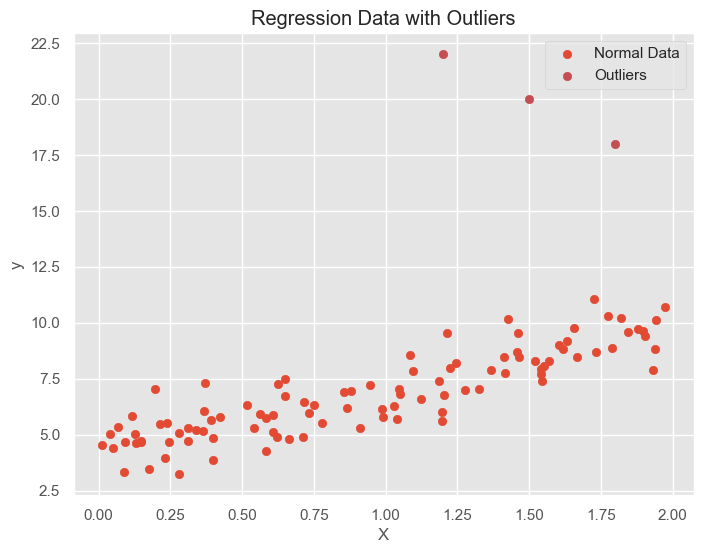

Performance without Outliers:
MSE: 0.6537, MAE: 0.5913, R²: 0.8072
Performance with Outliers:
MSE: 6.5629, MAE: 1.1686, R²: 0.4123


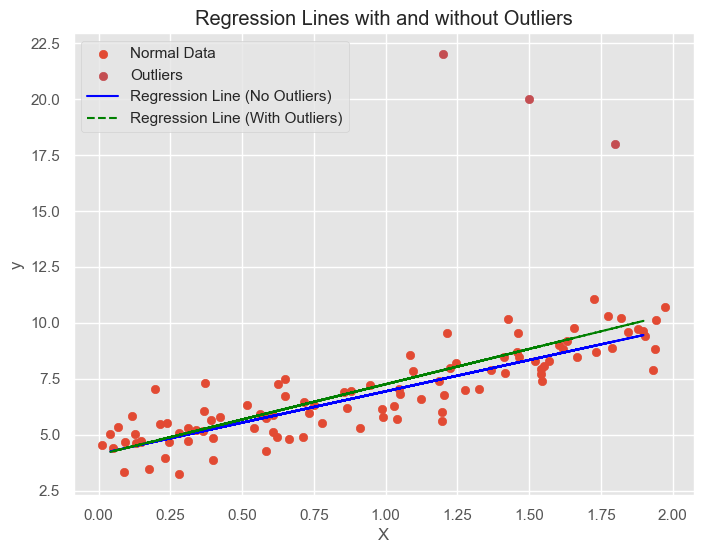

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Generate synthetic data for regression
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Introduce outliers
X_outliers = np.append(X, [[1.5], [1.8], [1.2]])
y_outliers = np.append(y, [[20], [18], [22]])

# Plot the data with outliers
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label="Normal Data")
plt.scatter([1.5, 1.8, 1.2], [20, 18, 22], color='r', label="Outliers")
plt.title("Regression Data with Outliers")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

# Split the data with outliers and without outliers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(X_outliers.reshape(-1, 1), 
                                                                                      y_outliers.reshape(-1, 1), 
                                                                                      test_size=0.2, random_state=42)

# Fit linear regression model without outliers
model_no_outliers = LinearRegression()
model_no_outliers.fit(X_train, y_train)
y_pred_no_outliers = model_no_outliers.predict(X_test)

# Fit linear regression model with outliers
model_with_outliers = LinearRegression()
model_with_outliers.fit(X_train_outliers, y_train_outliers)
y_pred_with_outliers = model_with_outliers.predict(X_test_outliers)

# Evaluate model performance without outliers
mse_no_outliers = mean_squared_error(y_test, y_pred_no_outliers)
mae_no_outliers = mean_absolute_error(y_test, y_pred_no_outliers)
r2_no_outliers = r2_score(y_test, y_pred_no_outliers)

# Evaluate model performance with outliers
mse_with_outliers = mean_squared_error(y_test_outliers, y_pred_with_outliers)
mae_with_outliers = mean_absolute_error(y_test_outliers, y_pred_with_outliers)
r2_with_outliers = r2_score(y_test_outliers, y_pred_with_outliers)

# Print model performance metrics
print(f"Performance without Outliers:\nMSE: {mse_no_outliers:.4f}, MAE: {mae_no_outliers:.4f}, R²: {r2_no_outliers:.4f}")
print(f"Performance with Outliers:\nMSE: {mse_with_outliers:.4f}, MAE: {mae_with_outliers:.4f}, R²: {r2_with_outliers:.4f}")

# Plot regression lines with and without outliers
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label="Normal Data")
plt.scatter([1.5, 1.8, 1.2], [20, 18, 22], color='r', label="Outliers")
plt.plot(X_test, y_pred_no_outliers, color='blue', label="Regression Line (No Outliers)")
plt.plot(X_test_outliers, y_pred_with_outliers, color='green', linestyle='dashed', label="Regression Line (With Outliers)")
plt.title("Regression Lines with and without Outliers")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


Original data size: 103
Data size after outlier removal (Z-Score method): 100


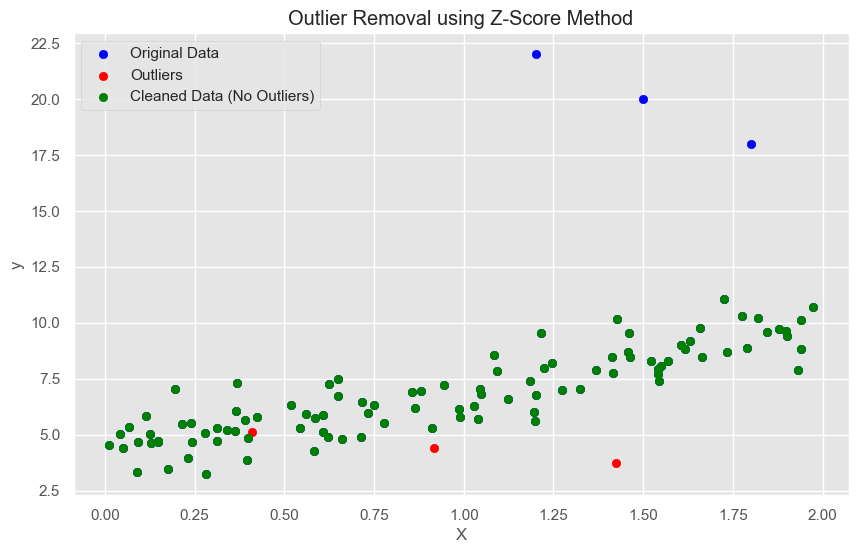

In [26]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Generate synthetic data for regression
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Introduce outliers
X_outliers = np.append(X, [[1.5], [1.8], [1.2]])
y_outliers = np.append(y, [[20], [18], [22]])

# Combine X and y into a DataFrame
df = pd.DataFrame(np.hstack([X_outliers.reshape(-1, 1), y_outliers.reshape(-1, 1)]), columns=["X", "y"])

# Compute Z-scores for each column
df_zscores = df.apply(zscore)

# Set a threshold for identifying outliers
z_threshold = 3

# Identify rows where any z-score exceeds the threshold
outliers = df_zscores[(np.abs(df_zscores) > z_threshold).any(axis=1)]

# Remove the outliers
df_no_outliers = df[(np.abs(df_zscores) <= z_threshold).all(axis=1)]

print(f"Original data size: {df.shape[0]}")
print(f"Data size after outlier removal (Z-Score method): {df_no_outliers.shape[0]}")

# Plot original data and cleaned data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df["X"], df["y"], label="Original Data", color='blue')
plt.scatter(outliers["X"], outliers["y"], label="Outliers", color='red')
plt.scatter(df_no_outliers["X"], df_no_outliers["y"], label="Cleaned Data (No Outliers)", color='green')
plt.title("Outlier Removal using Z-Score Method")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


Original data size: 103
Data size after outlier removal (IQR method): 100


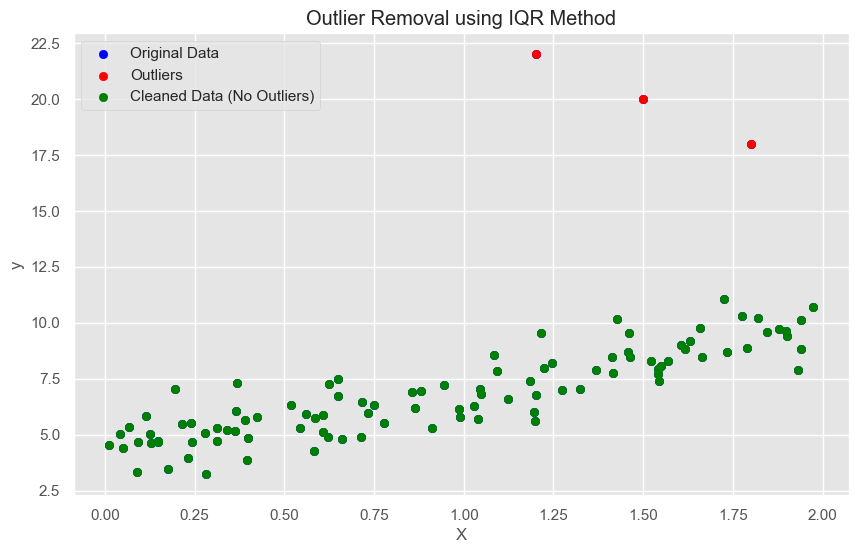

In [27]:
import numpy as np
import pandas as pd

# Generate synthetic data for regression (as before)
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Introduce outliers (as before)
X_outliers = np.append(X, [[1.5], [1.8], [1.2]])
y_outliers = np.append(y, [[20], [18], [22]])

# Combine X and y into a DataFrame
df = pd.DataFrame(np.hstack([X_outliers.reshape(-1, 1), y_outliers.reshape(-1, 1)]), columns=["X", "y"])

# Compute IQR for the y column
Q1 = df["y"].quantile(0.25)
Q3 = df["y"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df["y"] < lower_bound) | (df["y"] > upper_bound)]

# Remove outliers
df_no_outliers = df[(df["y"] >= lower_bound) & (df["y"] <= upper_bound)]

print(f"Original data size: {df.shape[0]}")
print(f"Data size after outlier removal (IQR method): {df_no_outliers.shape[0]}")

# Plot original data and cleaned data
plt.figure(figsize=(10, 6))
plt.scatter(df["X"], df["y"], label="Original Data", color='blue')
plt.scatter(outliers["X"], outliers["y"], label="Outliers", color='red')
plt.scatter(df_no_outliers["X"], df_no_outliers["y"], label="Cleaned Data (No Outliers)", color='green')
plt.title("Outlier Removal using IQR Method")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


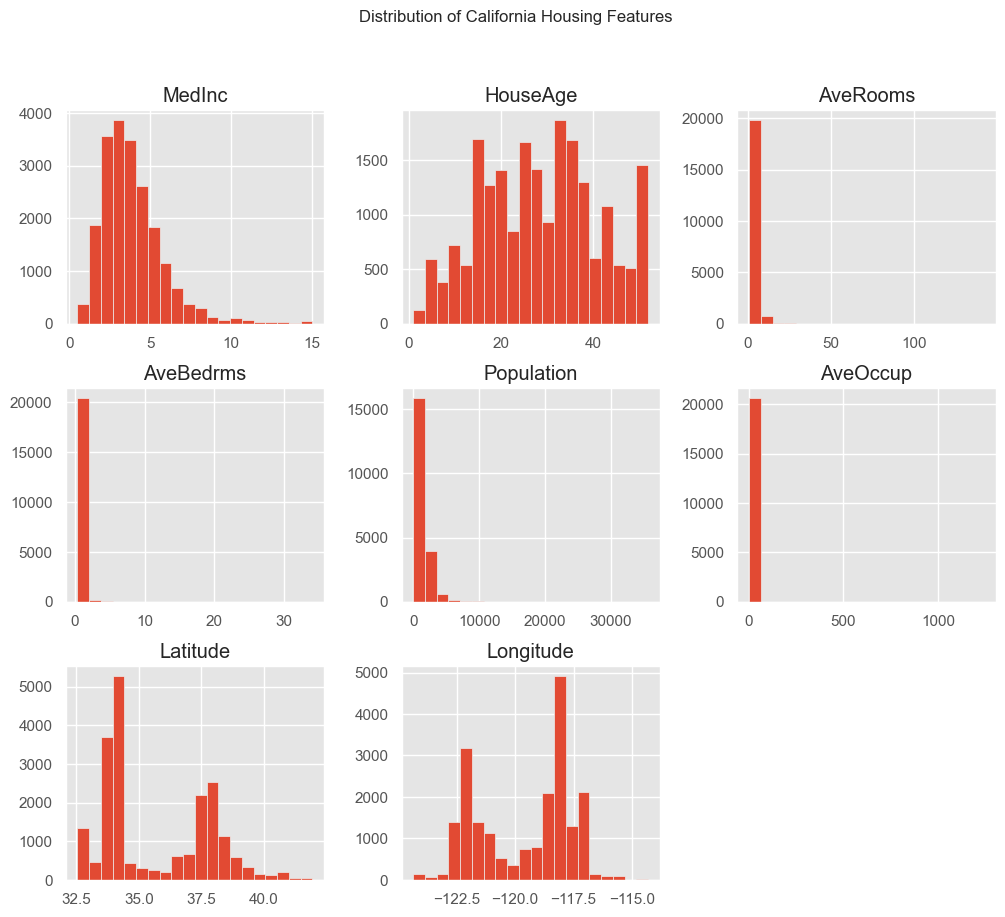

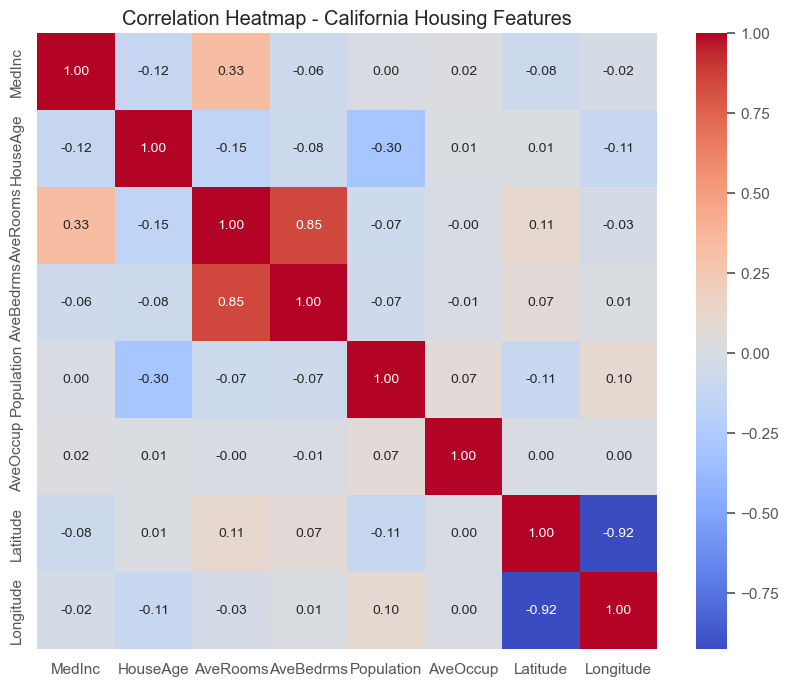

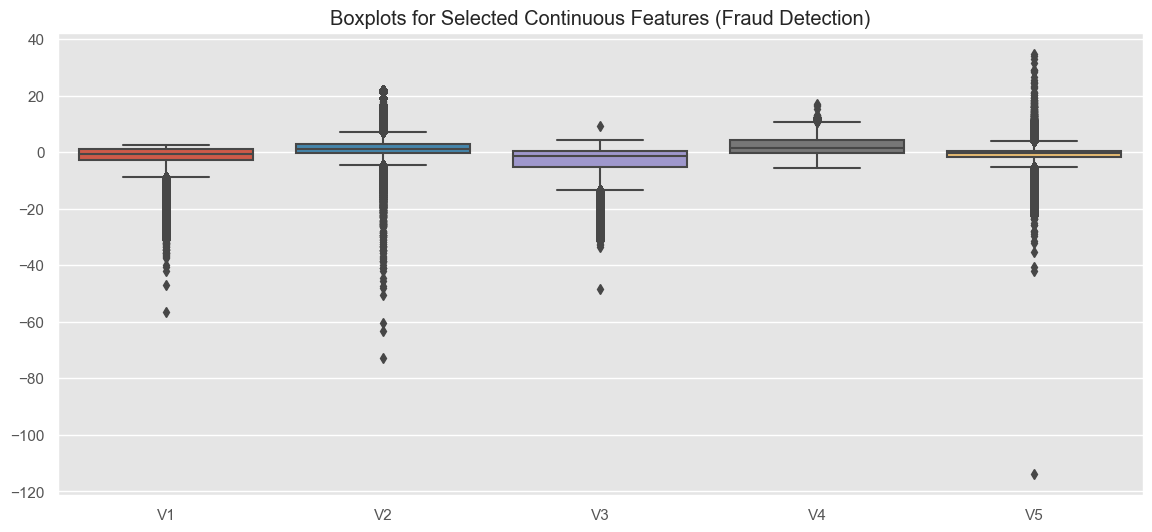

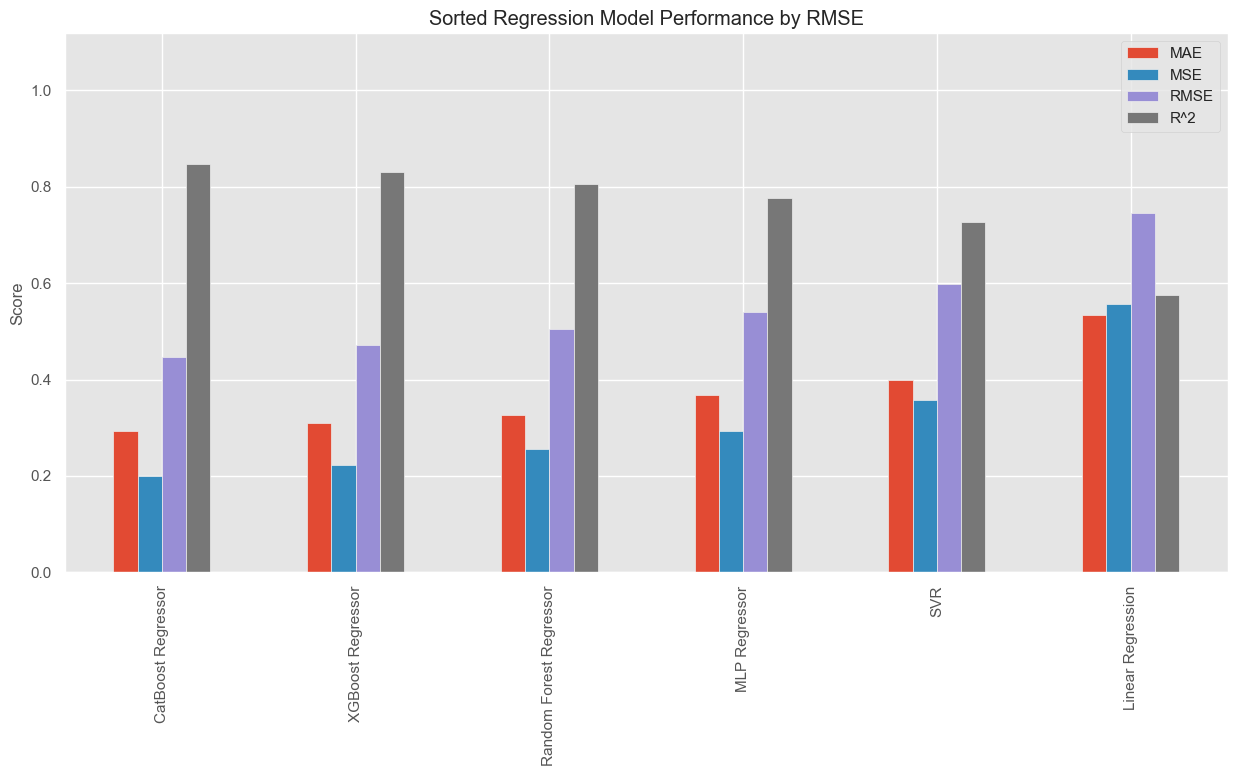

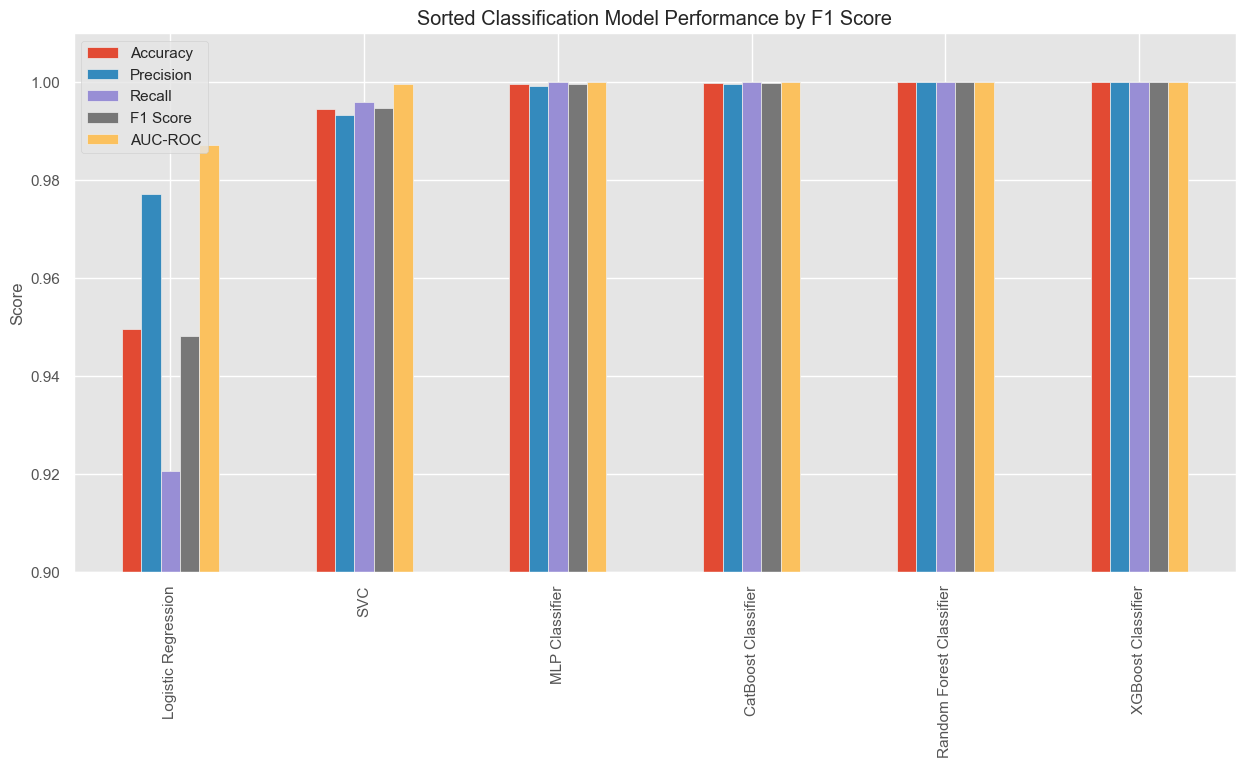

In [33]:
# Import necessary libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")
plt.style.use("ggplot")

### EDA Visualizations for Regression Data (California Housing Dataset)

# Plot histograms for regression features
X_reg.hist(figsize=(12, 10), bins=20)
plt.suptitle("Distribution of California Housing Features")
plt.show()

# Correlation heatmap for regression features
plt.figure(figsize=(10, 8))
sns.heatmap(X_reg.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap - California Housing Features")
plt.show()


# Boxplots for continuous features (selected few) in the fraud detection dataset
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_balanced[['V1', 'V2', 'V3', 'V4', 'V5']])
plt.title("Boxplots for Selected Continuous Features (Fraud Detection)")
plt.show()

### Sorted Model Performance Comparison Visualizations

# Sort regression results by RMSE (example metric) and plot
reg_results_df_sorted = reg_results_df.sort_values(by='RMSE', ascending=True)
reg_results_df_sorted.plot(kind='bar', figsize=(15, 7), title="Sorted Regression Model Performance by RMSE", ylabel="Score")
plt.ylim(0, reg_results_df_sorted['RMSE'].max() * 1.5)  # Adjust vertical axis limit for clarity
plt.show()

# Sort classification results by F1 Score (example metric) and plot
clf_results_df_sorted = clf_results_df.sort_values(by='F1 Score', ascending=True)
clf_results_df_sorted.plot(kind='bar', figsize=(15, 7), title="Sorted Classification Model Performance by F1 Score", ylabel="Score")
plt.ylim(0.9, clf_results_df_sorted['F1 Score'].max() * 1.01)  # Adjust vertical axis limit for clarity
plt.show()
